# GETTIN
## Planejamento de Equipamentos Escolares
## Método: Uncapacitaded Facility Location
### Versão: 1.0
#### Fillipe O Feitosa <fillipefeitosa@ua.pt>

---


\begin{array}{ll}
        \text{minimize}   & {\displaystyle \sum_{j \in J} f_j x_j + \sum_{j \in J} \sum_{i \in I} c_{ij} y_{ij}} \\
        \text{subject to} & {\displaystyle \sum_{j \in J} y_{ij}} = 1, \quad \forall i \in I, \\
                          & y_{ij} \leq x_{ij}, \quad \forall i \in I, \forall j \in J,  \\
                          & y_{ij} \geq 0, \quad \forall i \in I, \forall j \in J, \\
                          & x_j \in \{ 0, 1 \}, \quad \forall j \in J.
        \end{array}

#### Modeling and Creating Decision Variables

In [29]:
# Import Libraries
from gurobi import *
import math
import matplotlib.pyplot as plt

# Used to Create Visualization
from geojson import Feature, Point, FeatureCollection
import geopandas as gpd
import geojson

def distance(a,b):
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    return math.sqrt(dx*dx + dy*dy)

# Data
# Problem data

import geopandas as gpd

vagos = gpd.read_file('./data_gettin/vagos.geojson');
centroids = vagos.centroid

iteratorHandler = centroids.size
centroidVector = []
for centroid in centroids:
    obj = [centroid.xy[0][0], centroid.xy[1][0]]
    centroidVector.append(obj)

subSections = centroidVector
schools = centroidVector
# @charge: custo de construcao por escola (fixo em 500 mil euros)
charge = 500000

numSchools = len(schools)
numSubSections = len (subSections)

# Creting Guroby Model
m = Model()

# Decision Variables
x = {}
y = {}
d = {} # Distance Matrix
# @alpha: 0.29 de custo por Km  por (365 dias * 5 anos) 
alpha = 29.25

# creating binary variable for every school
for j in range(numSchools):
    x[j] = m.addVar(vtype=GRB.BINARY, name="%d" % j)

# creating continuous variable for subsections to check suply fractions
for i in range(numSubSections):
    for j in range(numSchools):
        # Fractions of Subsection Suply
        y[(i,j)] = m.addVar(lb=0, vtype=GRB.CONTINUOUS, name="Fração da Sub[%d], escola[%d]" % (i,j))
        # Distances between Subsections and Schools
        d[(i,j)] = distance(subSections[i], schools[j])

m.update()

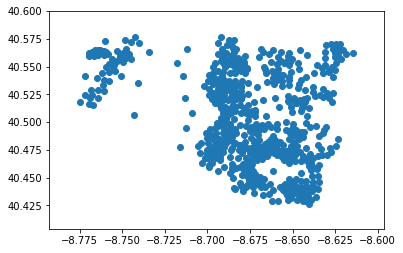

In [30]:
plt.scatter(*zip(*subSections))
plt.show()

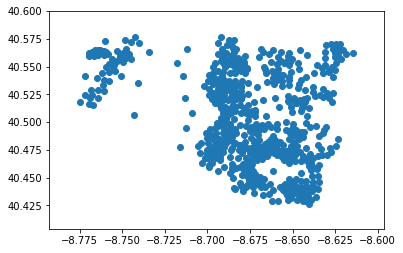

In [31]:
plt.scatter(*zip(*schools))
plt.show()

## Adding Constraints

In [32]:
# Constraint for Every Student on School
for i in range(numSubSections):
    m.addConstr(quicksum(y[(i,j)] for j in range(numSchools)) == 1)

# Fraction of suply must be lower or equal than the BINARY x[j] available 
for i in range(numSubSections):
    for j in range(numSchools):
        m.addConstr(y[(i,j)] <= x[j])
        



#### Objetive


In [33]:
# Setting objective

m.setObjective( quicksum(charge*x[j] + quicksum(alpha*d[(i,j)]*y[(i,j)]
                for i in range(numSubSections)) for j in range(numSchools)), GRB.MINIMIZE )


m.optimize()

Optimize a model with 480942 rows, 480942 columns and 1440747 nonzeros
Variable types: 480249 continuous, 693 integer (693 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-03, 5e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2.185014e+08
Presolve removed 0 rows and 0 columns (presolve time = 6s) ...
Presolve time: 6.04s
Presolved: 480942 rows, 480942 columns, 1440747 nonzeros
Variable types: 480249 continuous, 693 integer (693 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Presolved: 480942 rows, 480942 columns, 1440747 nonzeros

Presolve removed 480942 rows and 480942 columns

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4650160e+08   0.000000e+00   3.468755e+08      9s
  309111    5.0148532e+05   0.000000e+00   8.584145e+07     10s
  317658    5.0112649e+05   0.000000e+00   1.235

In [34]:
a = m.getVarByName("19")
a

<gurobi.Var 19 (value -0.0)>

In [35]:
# Used to get the Index of Schools from the M Model Optimized
listOfResults = []
for e in range(numSchools):
    tempObj = m.getVarByName(str(e))
    # If This School is on the Results Optimized
    if(tempObj.x != 0):
        listOfResults.append(int(tempObj.varName))
        
# Select, from the List Of Results, A set of Centroid Points 
listOfPoints = []
for schoolNumber in listOfResults:
    # Attention to the Feature(geometry) from geopandas
    listOfPoints.append(Feature(geometry=centroids[schoolNumber]))

# Creating a FeatureCollection with the Features (Points) manipulated above
resultCentroids = FeatureCollection(listOfPoints)

In [38]:
# Write Feature Collection to GeoJson File
dump = geojson.dumps(resultCentroids, sort_keys=True)
with open('./data_gettin/uncapacidated-%d x %d.geojson' % (charge,alpha), 'w') as outfile:
      geojson.dump(resultCentroids, outfile)

In [39]:
m

<gurobi.Model MIP instance Unnamed: 480942 constrs, 480942 vars, Parameter changes: LogFile=gurobi.log, CSIdleTimeout=1800>

In [40]:
print('Obj: %g' % m.objVal)

Obj: 500989


In [41]:
for v in m.getVars():
    if(v.x != 0):
       print('%s   %g' % (v.varName, v.x))

690   1
Fração da Sub[0], escola[690]   1
Fração da Sub[1], escola[690]   1
Fração da Sub[2], escola[690]   1
Fração da Sub[3], escola[690]   1
Fração da Sub[4], escola[690]   1
Fração da Sub[5], escola[690]   1
Fração da Sub[6], escola[690]   1
Fração da Sub[7], escola[690]   1
Fração da Sub[8], escola[690]   1
Fração da Sub[9], escola[690]   1
Fração da Sub[10], escola[690]   1
Fração da Sub[11], escola[690]   1
Fração da Sub[12], escola[690]   1
Fração da Sub[13], escola[690]   1
Fração da Sub[14], escola[690]   1
Fração da Sub[15], escola[690]   1
Fração da Sub[16], escola[690]   1
Fração da Sub[17], escola[690]   1
Fração da Sub[18], escola[690]   1
Fração da Sub[19], escola[690]   1
Fração da Sub[20], escola[690]   1
Fração da Sub[21], escola[690]   1
Fração da Sub[22], escola[690]   1
Fração da Sub[23], escola[690]   1
Fração da Sub[24], escola[690]   1
Fração da Sub[25], escola[690]   1
Fração da Sub[26], escola[690]   1
Fração da Sub[27], escola[690]   1
Fração da Sub[28], esc

In [42]:
m = None

In [43]:
disposeDefaultEnv()